In [1]:
%matplotlib inline
!pip install tqdm
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import os
os.environ['DATA_PATH'] = '/root/work/data'

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k + 1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k

def repeated(func, X, nb_iter=100, random_state=None, verbose=0, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []

    iters = range(nb_iter)
    if verbose > 0:
        iters = tqdm(iters)    
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results


In [9]:
from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 1.43192309,  1.53192309,  1.63192309,  1.73192309,  1.83192309,
         1.93192309,  2.03192309,  2.13192309,  2.23192309,  2.33192309,
         2.43192309]),
 <a list of 10 Patch objects>)

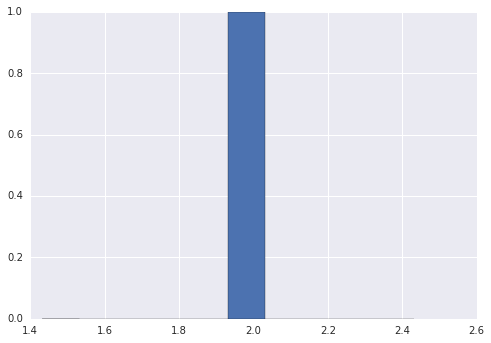

In [10]:
k1 = 10
k2 = 20
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, mode='same', nb_iter=1, 
                             verbose=1, k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
plt.hist(intdim_k_repeated.mean(axis=1))

In [16]:
from lasagnekit.datasets.mnist import MNIST
data = MNIST()
data.load()
X = data.X[0:10000]

In [ ]:
k1 = 10
k2 = 20
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, mode='bootstrap', nb_iter=100, 
                             verbose=1, k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
plt.hist(intdim_k_repeated.mean(axis=1))


  9%|▉         | 9/100 [1:23:19<13:58:46, 553.04s/it]

In [18]:
print(intdim_k_repeated)

[[ 13.15947674  13.10277159  13.03472758 ...,  12.87135046  12.8542989
   12.83735072]
 [ 13.11799334  13.08555799  13.04474308 ...,  12.91388303  12.88968548
   12.85011337]
 [ 13.15406806  13.11825039  13.08325673 ...,  12.93940533  12.93124646
   12.90796922]
 ..., 
 [ 13.16657796  13.11086159  13.04787767 ...,  12.92200077  12.89898032
   12.8833116 ]
 [ 13.30424474  13.27202288  13.24708781 ...,  12.97689719  12.96116182
   12.9342292 ]
 [ 13.11812841  13.06412814  13.02971242 ...,  12.87378182  12.84768687
   12.82942344]]
